# Conditional GAN

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/13<br>
**Last modified:** 2025/25/25<br>
**Modified by Gustavo Flores<br>
**Description:** Training a GAN conditioned on class labels to generate new clothes

Modified for detect Fashion Minst (Prototipe)



cGAn

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [2]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy("mixed_float16")

## Constants and hyperparameters

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

## Loading the MNIST dataset and preprocessing it

In [4]:
# Cargar y preprocesar datos (Fashion MNIST)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Normalizar y añadir canal
all_digits = all_digits.astype('float32') / 127.5 - 1.0  # [-1, 1]
all_digits = np.expand_dims(all_digits, axis=-1)  # (60000, 28, 28, 1)

# Convertir etiquetas a one-hot
all_labels = keras.utils.to_categorical(all_labels, num_classes)  # (60000, 10)

# Crear Dataset
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [5]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [22]:
# Generador
def build_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(num_classes,))

    # Concatenar ruido y etiquetas
    x = layers.Concatenate()([noise_input, label_input])

    x = layers.Dense(7 * 7 * 128)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    image_output = layers.Conv2D(1, (7,7), padding="same", activation="tanh")(x)

    return keras.Model([noise_input, label_input], image_output)

# Discriminador
def build_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 1))
    label_input = keras.Input(shape=(num_classes,))

    # Expandir etiquetas para concatenar con imágenes
    label_reshaped = layers.Reshape((1, 1, num_classes))(label_input)
    label_tiled = layers.UpSampling2D(size=(image_size, image_size))(label_reshaped)

    # Concatenar imagen y etiquetas
    x = layers.Concatenate()([image_input, label_tiled])

    x = layers.Conv2D(256, (3,3), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5,5), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalMaxPooling2D()(x)
    validity_output = layers.Dense(1)(x)

    return keras.Model([image_input, label_input], validity_output)

## Creating a `ConditionalGAN` model

In [23]:
## 3. Modelo ConditionalGAN CORREGIDO
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, real_labels = data

        batch_size = tf.shape(real_images)[0]

        # Generar imágenes falsas
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.random.uniform(shape=(batch_size,), minval=0, maxval=num_classes, dtype=tf.int32)
        random_one_hot_labels = tf.one_hot(random_labels, depth=num_classes)

        # Cast random_one_hot_labels to float64 to match real_labels
        random_one_hot_labels = tf.cast(random_one_hot_labels, dtype=tf.float64) # This line was added to cast random_one_hot_labels to float64

        generated_images = self.generator([random_latent_vectors, random_one_hot_labels])

        # Cast generated_images to float32 to match real_images
        generated_images = tf.cast(generated_images, dtype=tf.float32) # Cast to float32

        # Combinar imágenes reales y falsas
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_labels = tf.concat([random_one_hot_labels, real_labels], axis=0)

        # Etiquetas para el discriminador (1 = real, 0 = falso)
        disc_labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Entrenar discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(disc_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Entrenar generador
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, random_one_hot_labels])
            predictions = self.discriminator([fake_images, random_one_hot_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Actualizar métricas
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

## Training the Conditional GAN

In [24]:
## 4. Compilación y Entrenamiento
generator = build_generator()
discriminator = build_discriminator()

cond_gan = ConditionalGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Entrenamiento
cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - d_loss: 0.4183 - g_loss: 1.6313
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.5097 - g_loss: 1.2274
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.5569 - g_loss: 1.1033
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - d_loss: 0.5818 - g_loss: 1.0371
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.5919 - g_loss: 0.9984
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - d_loss: 0.5966 - g_loss: 0.9936
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.6009 - g_loss: 0.9928
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.6036 - g_loss: 0.9849
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.6049 - g_loss: 0.9782
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.6070 - g_loss: 0.9824
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - d_loss: 0.6068 - g_loss: 0.9787
Epoch 12

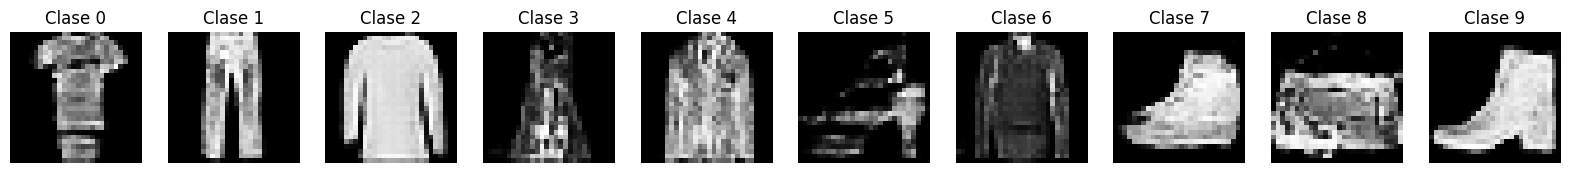

In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Parámetros
latent_dim = 128
num_classes = 10
generator = cond_gan.generator  # El generador entrenado

# Generar un vector de ruido y etiquetas one-hot para cada clase
noise = tf.random.normal([num_classes, latent_dim])
labels = tf.eye(num_classes)  # Matriz identidad = one-hot

# Generar imágenes falsas condicionadas
generated = generator.predict([noise, labels], verbose=0)

# Reescalar imágenes de [-1,1] a [0,1] para visualización
generated = (generated + 1) / 2.0

# Mostrar imágenes en una fila
fig, axes = plt.subplots(1, num_classes, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated[i, :, :, 0], cmap='gray')
    ax.set_title(f"Clase {i}")
    ax.axis('off')
plt.show()


## Interpolating between classes with the trained generator

In [ ]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    # The line below was modified to pass noise and labels as separate inputs
    fake = trained_gen.predict([interpolation_noise, interpolation_labels])
    return fake


start_class = 9  # @param {type:"slider", min:0, max:9, step:1}
end_class = 0  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label identities being present in some proportion.


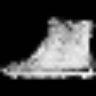

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).